# Systematic HyperParameters Optimization (SHPsO) with Random Search for Hydrological Prediction using LSTMs

This code is for paper: "Ensemble Learning of Catchment-Wise Optimized LSTMs Enhances Regional Rainfall-Runoff modelling - Case Study: Basque Country, Spain" by Hosseini et al. 2024 (Preprint - under review)

# Overview

        This code outlines a systematic hyperparameter tuning approach using random search and the proposed approach for ensemble learning of optimized LSTMs in regional hydrology, specifically tailored for hydrological prediction using LSTMs. While the example focuses on Multi-Timescale LSTM (MTS-LSTM), the methodology can be adapted for other Deep Learning models.

**Steps**

1. Hyperparameter Space Definition ()
        
        Description: Define the hyperparameters, specifying their ranges and values for simultaneous tuning.
        Details: In this study, 10 hyperparameters with two schedules for learning rate were chosen for tuning, as detailed in the associated paper.

2. Random Search Training and validation

        Description: Execute random searches within the predefined hyperparameter space.
        Details:
        Initial Configuration: 1000 randomly tuned configurations.

        Steps 1 and 2 are the same as a previous paper:
        Hosseini Hossein Abadi, Farzad and Prieto Sierra, Cristina and Álvarez Díaz, Cesar, "Precise Tuning of Regional Hydrological Lstm Networks: Simultaneous Systematic Random Search Optimization."
        Available at SSRN: https://ssrn.com/abstract=4815562 or http://dx.doi.org/10.2139/ssrn.4815562 (Under Review)
        The codes and dataset utilized in that study, along with comprehensive instructions for replicating the experiments, are accessible on our repositories on https://github.com/farzadhoseini/Precise_Tuning_of_Regional_Hydrological_LSTM_Networks and https://doi.org/10.5281/zenodo.11092080.

        All the steps for designing the hyperparameter space and performing 1000 random searches are the same and from the mentioned paper.
        Here in this new paper, we continue with new steps post-random search. We chose three different ensemble configurations as the following steps present and compare the outcomes after retraining with the best network from the preious paper (ERO network) as the benchmarck.

3. Analysis of validation Metrics (Post-random search validation DATASET)

        Description: Analyze the results to identify optimal hyperparameter configurations.
        Details:
        Post-Random Sraech validation DATASET Structure:
        Configurations: 1000 (594 successful) lines
        Basins: Every configuration results in 25 distinct NSE and KGE metrics for 25 basins with validation data; later we tested final hyper-tuned models' performance on all 40 basins.
        Metrics: KGE and NSE values for each basin
        Analysis Approach:
        Regional Analysis: Averaging metrics across all basins for each configuration for ERO network
        Catchment-scale Analysis: Evaluating each basin individually for Catchment-wise Configs ensemble
        Top 10 Configs Analysis: Averaging metrics across all basins for each configuration to find the top 10 Configs ensemble (ERO was the first)
        K-means Clustering Analysis: Evaluating each basin individually by K-means clustering to find the best Configs ensembles

        We explored different ensemble learning approaches for selecting configurations rather than relying solely on the regionally best-performing configuration (ERO network). Ultimately, we adopted 3 approaches for this purpose:
        1 - Top 10 Configs: We selected the top ten regionally best-performing configurations on the validation set after 1000 random searches; this ensemble included ERO.
        2 - Catchment-wise Configs: Recognizing the uniqueness of the catchments in shaping their hydrological behaviors, we chose the best-performing regional configurations for each catchment individually, regarding its validation metrics. Since validation data was available for only 25 basins, this approach yielded 23 unique configurations, with some overlap in certain cases at the end.
        3 - K-means Configs: To minimize cognitive bias in the configuration selection process, we employed a K-means Clustering unsupervised machine learning model. This model was trained on the normalized post-random search validation DATASET to select an ensemble of best-performing regional configurations. After experimenting with different numbers of clusters, we converged on 8 configurations chosen by the K-means Clustering model, representing a cluster with the highest overall average metrics in several tries.

        Outcome: The best-performing configuration was selected based on the highest average NSE and KGE metrics across all 25 basins after both 100 and 1000 random searches.

4. Training the three ensemble learning methods and benchmarking against ERO

        Description: Train the final models identified post-random search optimized configurations.
        Training Runs: Conduct 10 training runs using 10 different random seeds for each selected configuration.
        Generate ensembles' final predictions (medians of predictions by all configurations in every ensemble on every time step on each random seed)
        Outcome: Each method produces an ensemble of 10 predictions, accompanied by their respective metrics for each catchment. This way we could compare the four different approaches.
        Comparisons: we plotted box plots in all basins and also CDFs of the metrics and we performed statistical tests to make sure if predictions by different methods are significantly different.
        

In [17]:
"""
=================== Import required libraries ===================
"""
import csv
import ast
import os
import yaml
import pickle
import shutil
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.patches as mpatches
import os
import pandas as pd
import yaml
from pathlib import Path

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sys
sys.path.append(r'C:\Users\~\neuralhydrology') # In case of using VSC, this can help to activate and run libraries installed
# In our experiments we employed NeuralHydrology Python Library (Kratzert et al., (2022). NeuralHydrology --- A Python library for Deep Learning research in hydrology. 
# Journal of Open Source Software, 7(71), 4050, https://doi.org/10.21105/joss.04050)

from neuralhydrology.nh_run import start_run, Config
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run_scheduler import schedule_runs
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.metrics import mean_squared_error, r2_score


## Random Search Setup

    Ensuring the randomness and uniformity of the random search algorithm is crucial for effective hyperparameter tuning. Here's how we addressed this in our approach:

# Parameter Grid Design

    Objective: Cover the entire range of values within the hyperparameter space.
    Implementation:
    We designed a diverse grid for each hyperparameter based on consultations and initial trial and error.
    Recommendation: Before applying this approach to a new dataset, researchers are advised to conduct manual trials on select basins to determine an appropriate hyperparameter space for their regional model.

# Random Sampling Mechanism

    Objective: Achieve uniform sampling across the hyperparameter space.
    Implementation:
    We utilized ParameterSampler from scikit-learn's model_selection module.
    This mechanism ensures each hyperparameter combination is selected with equal probability, maintaining randomness and uniformity.

# Number of Samples
    
    Objective: Generate sufficient samples to explore the hyperparameter space adequately.
    Implementation:
    We set the number of samples to n_samples = 1000, considering the size and complexity of the hyperparameter grid.

# Independent Sampling

    Objective: Ensure each hyperparameter combination is sampled independently.
    Implementation:
    ParameterSampler was employed to sample each hyperparameter independently, preserving the randomness and uniformity of the sampling process.

## Code for Generating Random Configurations

    The following code generates 1000 random hyperparameter configurations for the models to be trained in subsequent steps. This approach provides a broad exploration of the hyperparameter space.

# Considerations for Customization

    Initial Exploration:
    You can begin with a smaller number of random searches and evaluate the verification outcomes.
    This allows for a more focused selection of hyperparameter configurations by narrowing down the hyperparameter space based on the observed performance.

# Replicating the Experiment
    
    Note: To replicate our exact experiment, please run the generated random configurations available in the supplementary folder.
    Recommendation for flexibility:
    While our code provides a specific set of random configurations, we encourage researchers to experiment with varying levels of randomness to potentially discover optimized configurations for their specific datasets and models.    

In [2]:
"""
============= Code to create 1000 random configs ===================
"""

# Create a new folder for the config files
Path = r"...\Supplementary_materials"
config_folder = Path("Config_Hypertuning_files_paper_experiment")
config_folder.mkdir(exist_ok=True)

# Define the hyperparameter grid for random search
param_grid = {
    'hidden_size': [16, 32, 64, 128, 256],
    'initial_forget_bias': [-3, -1, 0, 1, 3],
    'output_dropout': [0, 0.2, 0.4],
    'batch_size': [32, 64, 128, 256],
    'learning_rate': [{0: lr_1, 10: lr_2, 25: lr_3} for lr_1 in [1e-3, 1e-2, 5e-2]
                      for lr_2 in [5e-4, 1e-3, 5e-3] for lr_3 in [1e-4, 1e-3]],
    'target_noise_std': [0, 0.01, 0.02, 0.05, 0.1],
    'loss': ['NSE', 'RMSE'], # {1, 2}
    'regularization': ['tie_frequencies', None], # {1, 0}
    'seq_length': [{'1D': length_1, '1H': length_2} for length_1 in [146, 182, 365, 730, 1095]
                   for length_2 in [168, 336, 504, 672, 1344, 2016, 4032, 6720, 8064, 8760]],
}

# Specify the number of random samples to generate
n_sample = 1000

# Create a sampler to generate random hyperparameters
param_sampler = ParameterSampler(param_grid, n_iter=n_sample)

# Create an empty dictionary to store the results
results = {}
output_results = {}

# Loop through each set of hyperparameters
for i, params in enumerate(param_sampler):
    try:
        # Create a new configuration file with a unique name based on the current set of hyperparameters
        config_file = config_folder / Path(f"Config_Hypertuning_{i}.yml")

        # Load the original configuration file and create a copy
        config = yaml.load(Path("config_mts_LSTM.yml").read_text(), Loader=yaml.SafeLoader)
        config_copy = config.copy()

        # Update the copy with the current set of hyperparameters
        config_copy.update(params)

        # Write the updated configuration to the new file
        config_file.write_text(yaml.dump(config_copy, default_flow_style=False))

    except Exception as e:
        print(f"Error occurred for params {params}: {e}")
        continue  # continue to the next set of hyperparameters

print("Config files have been created and saved in the Config files folder")

Config files have been created and saved in the Config files folder


In [ ]:
"""
============= Code to Run multiple trainings in parallel by NeuralHydrology Python library ===================
"""

config_folder = Path("Config_Hypertuning_files_paper_experiment")

# Set the mode, directory, GPU IDs, and runs per GPU
mode = "train"
directory = config_folder
gpu_ids = [0, 1]  # List of GPU IDs to use (We had 2 GPUs cluster with 7 CPUs)
runs_per_gpu = 5  # Number of runs to start on a single GPU depending on the resources. We could not increase to more than 5.

try:
    # Call the schedule_runs function
    schedule_runs(mode, directory, gpu_ids, runs_per_gpu)

except Exception as e:
    print(f"An error occurred during execution: {e}")


In [ ]:
"""
=================== After hypertuning finished and we want to only read folders ===================
                        Extracting Hyperparameters and validation results
"""

# Define the parent directory that contains the folders with config files
parent_dir = r'...\Supplementary_materials\Hypertuning' 
# Since 1000 Randomly trained models are too much data, we could not upload them all but after you run hypertuning, can use the following code to extract results from your experiment.

# Set the directory for the results
results_dir = Path(r'...\Supplementary_materials\Results')

# Define the list of parameters to extract from the config files
params = {
    'hidden_size',
    'initial_forget_bias',
    'output_dropout',
    'batch_size',
    'learning_rate',
    'target_noise_std',
    'regularization',
    'seq_length',
    'loss',
    'seed'
}

# Create an empty dictionary to store the results
hyperparameters_list = []

# Iterate over the folders in the parent directory
for folder_name in os.listdir(parent_dir):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Create an empty dictionary to store the hyperparameters for this folder
        hyperparameters = {}
        # Read the config file for this folder
        try:
            config_path = os.path.join(folder_path, "config.yml")
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            # Extract the relevant hyperparameters from the config file
            for param in params:
                if param in config:
                    if param == 'learning_rate':
                        # Extract the individual learning rate values and add them as separate columns
                        lr_dict = config[param]
                        hyperparameters["Lr0"] = lr_dict.get(0, None)
                        hyperparameters["Lr10"] = lr_dict.get(10, None)
                        hyperparameters["Lr25"] = lr_dict.get(25, None)
                    elif param == 'seq_length':
                        # Extract the individual sequence length values and add them as separate columns
                        seq_dict = config[param]
                        hyperparameters["Seq_1D"] = seq_dict.get('1D', None)
                        hyperparameters["Seq_1H"] = seq_dict.get('1H', None)
                    else:
                        # Add the parameter value to the dictionary
                        hyperparameters[param] = config[param]
            # Add the folder name as a new column in the dictionary
            hyperparameters["Model"] = folder_name
            # Append the dictionary to the list of results
            hyperparameters_list.append(hyperparameters)
        except Exception as e:
            print(f"Error occurred for params {folder_name}: {e}")
            continue  # continue to the next set of hyperparameters

# Convert the list of dictionaries to a DataFrame
df_H = pd.DataFrame(hyperparameters_list)

# Create an empty dataframe to store the results
df_V = pd.DataFrame()

# Iterate through all the subfolders in the parent directory
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        print("Processing folder:", folder_path)
        
        # Navigate to the validation_results.p file
        validation_path = os.path.join(folder_path, "validation", "model_epoch050", "validation_results.p")
        try:
            results = {}
            output_results = {}
            # Load the validation results
            with open(validation_path, "rb") as f:
                results = pickle.load(f)

                # Store the results in the result dictionary with the params as the key
                output_results[folder] = results  

                # Loop through each set of hyperparameters
                for params, metrics in output_results.items():
                    # Loop through each basin and frequency
                    for basin, freq_metrics in metrics.items():
                        for freq, metric_values in freq_metrics.items():
                            # Ignore the xr key and extract the other metrics
                            metrics_dict = {k:v for k,v in metric_values.items() if k != 'xr'}
                            
                            # Append the metrics and hyperparameters to the dataframe
                            row_dict = {'basin': basin, 'freq': freq, 'Model': params, **metrics_dict}
                            df_V = pd.concat([df_V, pd.DataFrame([row_dict])], ignore_index=True)
#                            df_V = df_V.append(row_dict, ignore_index=True)
                        
                # Delete the results object from memory to free up space
                del results
                del output_results

        except Exception as e:
            print(f"Error occurred for params {folder}: {e}")
            continue  # continue to the next set of hyperparameters

# Merge columns with the same name prefix, keeping non-NaN values
df_new = df_V.groupby(df_V.columns.str.replace('_1H|_1D', '', regex=True), axis=1).apply(lambda x: x.ffill(axis=1).iloc[:, -1]).astype(str)

# Rename the columns to remove the '_1H' and '_1D' suffixes
df_new.columns = df_new.columns.astype(str).str.rstrip('_1H').str.rstrip('_1D')

# Merge the two DataFrames based on the "folder_name" column
df_merged = pd.merge(df_H, df_new, on="Model")

df_merged['Model'] = df_merged['Model'].str.replace("Hypertuning_URA40Basins_", "").str.replace("_", "")

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
                'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'basin', 'freq', 
                'streamflowmean_NSE', 'levelmean_NSE', 'streamflowinst_NSE', 'levelinst_NSE',
                'streamflowmean_KGE', 'levelmean_KGE', 'streamflowinst_KGE', 'levelinst_KGE']

# Define the mapping from old names to new names
column_mapping = {
    'streamflowmean_NSE': 'SFmean_NSE',
    'levelmean_NSE': 'WLmean_NSE',
    'streamflowinst_NSE': 'SFinst_NSE',
    'levelinst_NSE': 'WLinst_NSE',
    'streamflowmean_KGE': 'SFmean_KGE',
    'levelmean_KGE': 'WLmean_KGE',
    'streamflowinst_KGE': 'SFinst_KGE',
    'levelinst_KGE': 'WLinst_KGE'
}

df_merged = df_merged[column_order].rename(columns=column_mapping)

# Save the merged DataFrame to a new CSV file
df_merged.to_csv(results_dir /"merged_results.csv", index=False)


In [19]:
"""
=================== Removing outliers ===================
We manually removed configurations having overall average performance metrics less than 0.5 from the post-Random Search DATASET (including 24 Configs)
"""

# List of basin names to remove
models_to_remove = [
    '105042308',
    '908004510',
    '1008124856',
    '1108220501',
    '1408071538',
    '1708101122',
    '1908031551',
    '2008175336',
    '2108085859',
    '2408170627',
    '2508212427',
    '2607001222',
    '2608143652',
    '2608163243',
    '2608193453',
    '2704192907',
    '2708194303',
    '2708203837',
    '2807141344',
    '2904210252',
    '3004145131',
    '3007100701',
    '3007141119',
    '3107202900'
] # These are models that had average metrics on all URA basins < 0.5

# Filter the DataFrame to keep rows where the "basin" column is NOT in the specified list
filtered_df = df_merged[~df_merged['Model'].isin(models_to_remove)]

# List of basin names to remove (The ones that do not have verification data)
basins_to_remove = [
    'Abetxuko', 'Alegria', 'Araxes', 'Areta', 'Eibar',
    'Etura', 'Gatika', 'Jaizubia', 'Larrainazubi', 'Markina',
    'Ozaeta', 'Arenao', 'SanPrudentzio', 'Ibaieder', 'Sodupe'
] # These are basins that we decided to remove from verification checkup due to data deficiencies (only 25 out of 40 basins where considered to decide on the best configuration post-Random Search)

# Filter the DataFrame to keep rows where the "basin" column is NOT in the specified list
filtered_df = filtered_df[~filtered_df['basin'].isin(basins_to_remove)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv(os.path.join(results_dir, "_merged_results_DeepCleaned_All.csv"), index=False)


In [ ]:
"""
=================== To make SHPsT outcome, regionally out of basin scale ===================
"""

input_file_path = r'...\Supplementary_materials\Results\merged_results_DeepCleaned_All.csv'
data = pd.read_csv(input_file_path)
grouped_data = data.groupby(['Model', 'freq']).mean().reset_index()

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
                'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'freq', 
                'SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE']

grouped_data = grouped_data[column_order]

output_file_path = r'...\Supplementary_materials\Results\URA_merged_results_DeepCleaned_All.csv'
grouped_data.to_csv(output_file_path, index=False)


## Choose the best-performing LSTM network (ERO) regarding their overall regional perofrmance NSE and KGE metrics
## Choose the 10 best-performing LSTM networks (Top 10) regarding their overall regional perofrmance NSE and KGE metrics
## Choose the best-performing LSTM network in each catchment (Catchment-Wise) regarding their perofrmance NSE and KGE metrics

# The first three methods, use a sorted average metrics for URA_merged_results_DeepCleaned_All.csv

## Choose the best-performing LSTM network (K-means) regarding both their catchment-scale and overall regional perofrmance NSE and KGE metrics

# The last method uses the following codes to find the K-means configs.

## Update final configurations and generate 10 configs for each network regarding 10 different random seeds to be retrained and tested.


c:\Users\hosseinifh\AppData\Local\anaconda3\envs\neuralhydrology\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Statistics:
          SFmean_NSE  WLmean_NSE  SFinst_NSE  WLinst_NSE  SFmean_KGE  \
Cluster                                                               
1          0.770800    0.842090    0.772263    0.842590    0.785530   
2          0.773192    0.861862    0.774181    0.862168    0.788697   
3          0.805766    0.843301    0.806668    0.843453    0.795598   
4          0.772203    0.840377    0.773089    0.840627    0.778900   
5          0.781588    0.837859    0.782797    0.838481    0.781284   
6          0.769630    0.843648    0.770546    0.844040    0.777865   
7          0.775609    0.856485    0.777152    0.856956    0.792956   
8          0.777554    0.851210    0.778333    0.851296    0.780364   
9          0.805486    0.860508    0.806479    0.860911    0.798656   
10         0.760954    0.836313    0.761869    0.836729    0.771569   
11         0.775454    0.843892    0.776251    0.844299    0.779419   
12         0.802569    0.849768    0.803961    0.850228 

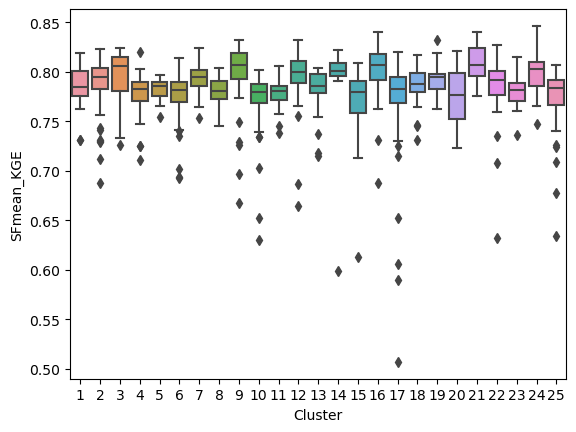

In [35]:
# K-means Clustering to find the best-performing Configs in the validation DATASET

"""
This script performs hyperparameter clustering and statistical analysis
        using KMeans, Seaborn Box Plot, and Pandas GroupBy.
        This is just a regional check to plot a regional plot for paper
        but the paper is based on basin metrics search not a regional average
"""

# Define the parent directory that contains the folders with config files
parent_dir = Path(r'...\Supplementary_materials\Results')

# Set the directory for the results
results_dir = Path(r'...\Supplementary_materials\Results\K_means')

# Load the data into a pandas DataFrame with column names
df = pd.read_csv(parent_dir / "URA_merged_results_DeepCleaned_All.csv", skiprows=[0],
                 names=['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
                'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'freq', 
                'SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE']).fillna(0)

# Specify the number of clusters
N_CLUSTERS = 25   

# Instantiate KMeans object and fit to data
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(df.drop(columns=['Model', 'seed', 'freq']).astype(float))

# Assign cluster labels to each data point
df['Cluster'] = kmeans.labels_ + 1

# Group the data by cluster and calculate the mean KGE and NSE for each cluster
cluster_stats = df.groupby('Cluster')[['SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE',
                       'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE']].mean()

# Print the cluster statistics
print("Cluster Statistics:\n", cluster_stats)

# Create a boxplot of the KGE values for each cluster
sns.boxplot(x='Cluster', y='SFmean_KGE', data=df)

# Find the label of the cluster with the highest metrics
best_cluster_label = cluster_stats['SFmean_KGE'].idxmax()

# Select the rows corresponding to the best cluster
best_cluster_df = df[df['Cluster'] == best_cluster_label]

# Print the DataFrame containing the best cluster
print("Best Cluster:\n", best_cluster_df)

# Save the best cluster DataFrame to a CSV file
best_cluster_df.to_csv(results_dir / 'best_cluster_reg.csv', index=False)

# Save the DataFrame containing the best clusters to a CSV file including the Model name
df.to_csv(results_dir / 'clusters_reg.csv', index=False)

# Get the current figure object
fig = plt.gcf()

# Save the figure as a high-quality TIFF file
fig.savefig(results_dir / 'Clusters_reg.tiff', dpi=300, format='tiff')


# Hyperparameters_configuration_selected.csv in the Supplementary_materials is the final file including all 37 optimized regional configurations from the four different approaches.
1. the ERO netdowk
2. 10 Top regional Configs
3. K-means regional selected Configs
4. 23 Catchment-wise Configs

Some of them are the same between different methods and all in all we had 37 distinct configurations.

In [44]:

"""
Updating Configs for best performing HPs after 1000 Random Searches
This code generates 370 configs that we will train them all (10 random seeds for every network)
"""

# Define the path to the CSV file
csv_directory = Path(r'...\Supplementary_materials\Results')
original_config_directory = Path(r'...\Supplementary_materials')

# The CSV file path
csv_path = csv_directory / "Hyperparameters_configuration_selected.csv"

# Define the output configuration folder
output_config_folder = Path(r'...\Supplementary_materials\post.RandomSearch_configs')

# Create the output folder if it doesn't exist
output_config_folder.mkdir(parents=True, exist_ok=True)

# Load CSV data
csv_data = pd.read_csv(csv_path)

# Read the original config
original_config = yaml.load((original_config_directory / "config_mts_LSTM.yml").read_text(), Loader=yaml.SafeLoader)

# Seeds to use
seeds = [893856, 202981, 970216, 723952, 931334, 846266, 339685, 64410, 105209, 370654]

# Iterate through rows of the CSV and update specific sections in the config
for index, row in csv_data.iterrows():
    for seed in seeds:
        # Create a new config based on the original config
        updated_config = original_config.copy()
        
        # Update seed value
        updated_config['seed'] = seed

        # Update specific sections with values from the CSV row
        updated_config['seq_length'] = {
            '1D': row['Seq_1D'],
            '1H': row['Seq_1H']
        }
        updated_config['batch_size'] = row['batch_size']
        updated_config['target_noise_std'] = row['target_noise_std']
        updated_config['learning_rate'] = {
            0: row['Lr0'],
            10: row['Lr10'],
            25: row['Lr25']
        }
        updated_config['loss'] = row['loss']
        updated_config['hidden_size'] = row['hidden_size']
        updated_config['output_dropout'] = row['output_dropout']
        updated_config['initial_forget_bias'] = row['initial_forget_bias']
        updated_config['regularization'] = [row['regularization']]
        updated_config['run_dir'] = f'runs/train_test/{row["name"]}'
        updated_config['experiment_name'] = row['name']

        # Generate the model name based on the "model" column
        model_name = f"{row['name']}_seed_{seed}"

        # Save the updated config to a new YAML file
        output_config_file = output_config_folder / f'{model_name}_config.yml'
        with open(output_config_file, 'w') as out_config_file:
            yaml.dump(updated_config, out_config_file, default_flow_style=False)

print("Updated configs have been saved.")


Updated configs have been saved.


In [ ]:
"""
============= Code to Run multiple retrainings in parallel for final hyper-tuned networks by NeuralHydrology Python library ===================
"""

config_folder = Path("post.RandomSearch_configs")

# Set the mode, directory, GPU IDs, and runs per GPU
mode = "train"
directory = config_folder
gpu_ids = [0, 1]  # List of GPU IDs to use (We had 2 GPUs cluster with 7 CPUs)
runs_per_gpu = 5  # Number of runs to start on a single GPU depending on the resources. We could not increase to more than 5.

try:
    # Call the schedule_runs function
    schedule_runs(mode, directory, gpu_ids, runs_per_gpu)

except Exception as e:
    print(f"An error occurred during execution: {e}")


In [ ]:
"""
============= To load all Training Folders for All networks and Test them on test set =============
                We will have 370 final fully trained/tested models networks
"""

# Define the parent directory that contains the folders with config files
parent_dir_cluster = r"...\Supplementary_materials\trained_models\ERO_Overfitting_Checked"                      # for ERO - Overfitting checked manually after retraining by Python Tensorboard
# parent_dir_cluster = r"...\Supplementary_materials\trained_models\Top10Configs_Overfitting_Checked"           # for Top10Configs Ensemble - Overfitting checked manually after retraining by Python Tensorboard
# parent_dir_cluster = r"...\Supplementary_materials\trained_models\K_means_Configs_Overfitting_Checked"        # for K_means_configured Ensemble - Overfitting checked manually after retraining by Python Tensorboard
# parent_dir_cluster = r"...\Supplementary_materials\trained_models\Catchment_Wise_Configs"                     # for Catchment-Wise Configs Ensemble - All mdoels after 50 epochs were taken

for folder_name in os.listdir(parent_dir_cluster):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir_cluster, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        try:
            run_config_path = os.path.join(folder_path, "config.yml")

            # Load the config.yml file
            with open(run_config_path, 'r') as file:
                run_config = yaml.safe_load(file)

            # Create an instance of the Config class
            cfg = Config(run_config)

            # create a tester instance and start evaluation
            tester = get_tester(cfg=cfg, run_dir=Path(folder_path), period="test", init_model=True)
            results = tester.evaluate(save_results=True, metrics=cfg.metrics)

            results.keys()

            print("Folder name:", folder_name)
            print("Config file path:", run_config_path)

        except Exception as e:
            print(f"Error occurred for folder {folder_name}: {e}")
            continue  # continue to the next folder


In [ ]:
"""
=================== After All Tests finished, we want to make output results file ===================
            Extracting Hyperparameters and test metrics for RO and ERO trained/tested models
"""

parent_dir = r"...\Supplementary_materials\trained_models\ERO_Overfitting_Checked"                      # for ERO
# parent_dir = r"...\Supplementary_materials\trained_models\Top10Configs_Overfitting_Checked"           # for Top10Configs Ensemble
# parent_dir = r"...\Supplementary_materials\trained_models\K_means_Configs_Overfitting_Checked"     # for K_means_configured Ensemble

# Set the directory for the results
results_dir = Path(r'...\Supplementary_materials\Results\test')

# Define the list of parameters to extract from the config files
params = {
    'hidden_size',
    'initial_forget_bias',
    'output_dropout',
    'batch_size',
    'learning_rate',
    'target_noise_std',
    'regularization',
    'seq_length',
    'loss',
    'seed'
}

# Create an empty dictionary to store the results
hyperparameters_list = []

# Iterate over the folders in the parent directory
for folder_name in os.listdir(parent_dir):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Create an empty dictionary to store the hyperparameters for this folder
        hyperparameters = {}
        # Read the config file for this folder
        try:
            config_path = os.path.join(folder_path, "config.yml")
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            # Extract the relevant hyperparameters from the config file
            for param in params:
                if param in config:
                    if param == 'learning_rate':
                        # Extract the individual learning rate values and add them as separate columns
                        lr_dict = config[param]
                        hyperparameters["Lr0"] = lr_dict.get(0, None)
                        hyperparameters["Lr10"] = lr_dict.get(10, None)
                        hyperparameters["Lr25"] = lr_dict.get(25, None)
                    elif param == 'seq_length':
                        # Extract the individual sequence length values and add them as separate columns
                        seq_dict = config[param]
                        hyperparameters["Seq_1D"] = seq_dict.get('1D', None)
                        hyperparameters["Seq_1H"] = seq_dict.get('1H', None)
                    else:
                        # Add the parameter value to the dictionary
                        hyperparameters[param] = config[param]
            # Add the folder name as a new column in the dictionary
            hyperparameters["Model"] = folder_name
            # Append the dictionary to the list of results
            hyperparameters_list.append(hyperparameters)
        except Exception as e:
            print(f"Error occurred for params {folder_name}: {e}")
            continue  # continue to the next set of hyperparameters

# Convert the list of dictionaries to a DataFrame
df_H = pd.DataFrame(hyperparameters_list)

# Create an empty dataframe to store the results
df_V = pd.DataFrame()

# Iterate through all the subfolders in the parent directory
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        print("Processing folder:", folder_path)
        
        # Navigate to the test_results.p file
        test_folder = os.path.join(folder_path, "test")
        for folder_test in os.listdir(test_folder):
            test_path = os.path.join(folder_path, "test", folder_test, "test_results.p")
        try:
            results = {}
            output_results = {}
            # Load the validation results
            with open(test_path, "rb") as f:
                # results = pickle.load(f)
                results = pd.read_pickle(f)
                # Store the results in the result dictionary with the params as the key
                output_results[folder] = results  

                # Loop through each set of hyperparameters
                for params, metrics in output_results.items():
                    # Loop through each basin and frequency
                    for basin, freq_metrics in metrics.items():
                        for freq, metric_values in freq_metrics.items():
                            # Ignore the xr key and extract the other metrics
                            metrics_dict = {k:v for k,v in metric_values.items() if k != 'xr'}
                            
                            # Append the metrics and hyperparameters to the dataframe
                            row_dict = {'basin': basin, 'freq': freq, 'Model': params, **metrics_dict}
                            df_V = pd.concat([df_V, pd.DataFrame([row_dict])], ignore_index=True)
                        
                # Delete the results object from memory to free up space
                del results
                del output_results

        except Exception as e:
            print(f"Error occurred for params {folder}: {e}")
            continue  # continue to the next set of hyperparameters

# Rename the columns to remove the '_1H' and '_1D' suffixes
df_V.columns = df_V.columns.astype(str).str.rstrip('_1H').str.rstrip('_1D')

# Merge columns with the same name prefix, keeping non-NaN values
df_new = df_V.groupby(df_V.columns.str.replace('_1H|_1D', '', regex=True), axis=1).apply(lambda x: x.ffill(axis=1).iloc[:, -1]).astype(str)

# Merge the two DataFrames based on the "folder_name" column
df_merged = pd.merge(df_H, df_new, on="Model")

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
                'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'basin', 'freq', 
                'streamflowmean_NSE',       'levelmean_NSE',        'streamflowinst_NSE',       'levelinst_NSE', 
                'streamflowmean_KGE',       'levelmean_KGE',        'streamflowinst_KGE',       'levelinst_KGE', 
                'streamflowmean_MSE',       'levelmean_MSE',        'streamflowinst_MSE',       'levelinst_MSE',
                'streamflowmean_RMSE',      'levelmean_RMSE',       'streamflowinst_RMSE',      'levelinst_RMSE', 
                'streamflowmean_Alpha-NSE', 'levelmean_Alpha-NSE',  'streamflowinst_Alpha-NSE', 'levelinst_Alpha-NSE', 
                'streamflowmean_Beta-NSE',  'levelmean_Beta-NSE',   'streamflowinst_Beta-NSE',  'levelinst_Beta-NSE',
                'streamflowmean_Pearson-r', 'levelmean_Pearson-r',  'streamflowinst_Pearson-r', 'levelinst_Pearson-r', 
                'streamflowmean_Beta-KGE',  'levelmean_Beta-KGE',   'streamflowinst_Beta-KGE',  'levelinst_Beta-KGE', 
                'streamflowmean_FHV',       'levelmean_FHV',        'streamflowinst_FHV',       'levelinst_FHV',
                'streamflowmean_FMS',       'levelmean_FMS',        'streamflowinst_FMS',       'levelinst_FMS', 
                'streamflowmean_FLV',       'levelmean_FLV',        'streamflowinst_FLV',       'levelinst_FLV', 
                'streamflowmean_Peak-Timing','levelmean_Peak-Timing', 'streamflowinst_Peak-Timing', 'levelinst_Peak-Timing',
                'streamflowmean_Peak-MAPE', 'levelmean_Peak-MAPE',  'streamflowinst_Peak-MAPE', 'levelinst_Peak-MAPE',
                'streamflowmean_Missed-Peaks', 'levelmean_Missed-Peaks',  'streamflowinst_Missed-Peaks', 'levelinst_Missed-Peaks']

# Define the mapping from old names to new names
column_mapping = {
    'streamflowmean_NSE': 'SFmean_NSE',
    'levelmean_NSE': 'WLmean_NSE',
    'streamflowinst_NSE': 'SFinst_NSE',
    'levelinst_NSE': 'WLinst_NSE',
    'streamflowmean_KGE': 'SFmean_KGE',
    'levelmean_KGE': 'WLmean_KGE',
    'streamflowinst_KGE': 'SFinst_KGE',
    'levelinst_KGE': 'WLinst_KGE',
    'streamflowmean_MSE': 'SFmean_MSE',
    'levelmean_MSE': 'WLmean_MSE',
    'streamflowinst_MSE': 'SFinst_MSE',
    'levelinst_MSE': 'WLinst_MSE',
    'streamflowmean_RMSE': 'SFmean_RMSE',
    'levelmean_RMSE': 'WLmean_RMSE',
    'streamflowinst_RMSE': 'SFinst_RMSE',
    'levelinst_RMSE': 'WLinst_RMSE',
    'streamflowmean_Alpha-NSE': 'SFmean_Alpha-NSE',
    'levelmean_Alpha-NSE': 'WLmean_Alpha-NSE',
    'streamflowinst_Alpha-NSE': 'SFinst_Alpha-NSE',
    'levelinst_Alpha-NSE': 'WLinst_Alpha-NSE',
    'streamflowmean_Beta-NSE': 'SFmean_Beta-NSE',
    'levelmean_Beta-NSE': 'WLmean_Beta-NSE',
    'streamflowinst_Beta-NSE': 'SFinst_Beta-NSE',
    'levelinst_Beta-NSE': 'WLinst_Beta-NSE',
    'streamflowmean_Pearson-r': 'SFmean_Pearson-r',
    'levelmean_Pearson-r': 'WLmean_Pearson-r',
    'streamflowinst_Pearson-r': 'SFinst_Pearson-r',
    'levelinst_Pearson-r': 'WLinst_Pearson-r',
    'streamflowmean_Beta-KGE': 'SFmean_Beta-KGE',
    'levelmean_Beta-KGE': 'WLmean_Beta-KGE',
    'streamflowinst_Beta-KGE': 'SFinst_Beta-KGE',
    'levelinst_Beta-KGE': 'WLinst_Beta-KGE',
    'streamflowmean_FHV': 'SFmean_FHV',
    'levelmean_FHV': 'WLmean_FHV',
    'streamflowinst_FHV': 'SFinst_FHV',
    'levelinst_FHV': 'WLinst_FHV',
    'streamflowmean_FMS': 'SFmean_FMS',
    'levelmean_FMS': 'WLmean_FMS',
    'streamflowinst_FMS': 'SFinst_FMS',
    'levelinst_FMS': 'WLinst_FMS',
    'streamflowmean_FLV': 'SFmean_FLV',
    'levelmean_FLV': 'WLmean_FLV',
    'streamflowinst_FLV': 'SFinst_FLV',
    'levelinst_FLV': 'WLinst_FLV',
    'streamflowmean_Peak-Timing': 'SFmean_Peak-Timing',
    'levelmean_Peak-Timing': 'WLmean_Peak-Timing',
    'streamflowinst_Peak-Timing': 'SFinst_Peak-Timing',
    'levelinst_Peak-Timing': 'WLinst_Peak-Timing',
    'streamflowmean_Peak-MAPE': 'SFmean_Peak-MAPE',
    'levelmean_Peak-MAPE': 'WLmean_Peak-MAPE',
    'streamflowinst_Peak-MAPE': 'SFinst_Peak-MAPE',
    'levelinst_Peak-MAPE': 'WLinst_Peak-MAPE',
    'streamflowmean_Missed-Peaks': 'SFmean_Missed-Peaks',
    'levelmean_Missed-Peaks': 'WLmean_Missed-Peaks',
    'streamflowinst_Missed-Peaks': 'SFinst_Missed-Peaks',
    'levelinst_Missed-Peaks': 'WLinst_Missed-Peaks'
}

df_merged = df_merged[column_order].rename(columns=column_mapping)
df_merged["Model"] = df_merged["Model"].str.replace("One_Fits_All_1000_", "").str.replace("_", "")

# Save the merged DataFrame to a new CSV file
df_merged.to_csv(results_dir /"ERO.metrics.csv", index=False)
# df_merged.to_csv(results_dir /"Top10Configs.metrics.csv", index=False)
# df_merged.to_csv(results_dir /"K_means.metrics.csv", index=False)


## Processing the results can be found on the other code in Supplementary_materials named: "Master_EnsembleDeepLearningInRegionalHydrology"